In [29]:
import numpy as np
import pandas as pd
import skimage.io
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

### Functions from nucleus segmentation competition that will help here

In [2]:
### This just gets rid of any problem files that MacOSX tends to put in for its own book keeping
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

### Support function to grab the dimensions of an image or mask
def get_image_dim(image_path):
    return skimage.io.imread(image_path).shape

In [3]:
def load_img(basedir, imgid):
    imgname = imgid + '.png'
    
    ### Load in the test image
    img = skimage.io.imread(basedir + imgid + '/images/' + imgname)
    
    return img    

def load_masks(basedir, imgid):
    ### Grab the mask file names
    mask_files = filter_directory_list(os.listdir(basedir + imgid + "/masks"))
    
    ### Load in the masks for the test image
    masks = np.array([skimage.io.imread(basedir + imgid + '/masks/' + mask) for mask in mask_files])
    
    ### Scale down to a 0 to 1 scale, which is needed for fast IoU calculation
    masks = masks / 255
    
    return masks

In [5]:
traindir = '../../train/'

train_image_files = os.listdir(filter_directory_list(traindir + 'images/'))
train_mask_files = os.listdir(filter_directory_list(traindir + 'masks/'))

Check to make sure the image and mask names exactly match

In [6]:
num_unique_images = len(train_image_files)
num_unique_masks = len(train_mask_files)
num_overlapping_image_mask = len(set(train_image_files).intersection(set(train_mask_files)))

num_unique_images, num_unique_masks, num_overlapping_image_mask

(4000, 4000, 4000)

In [30]:
images = np.array([skimage.io.imread(traindir + 'images/' + x) for x in tqdm_notebook(train_image_files)])
masks = np.array([skimage.io.imread(traindir + 'masks/' + x) for x in tqdm_notebook(train_mask_files)])

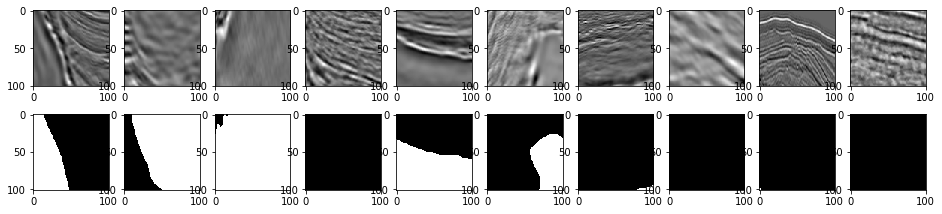

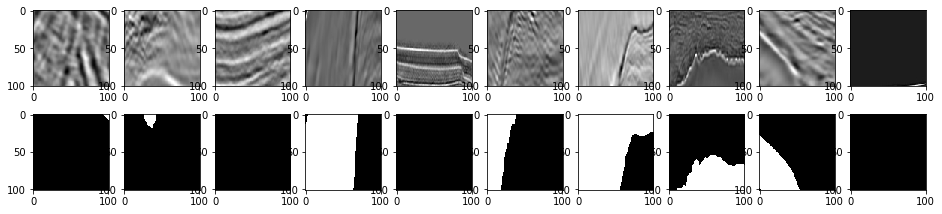

In [31]:
plt.figure(figsize=(16,3.5))
num_images = 10
for i in range(num_images):
    curr_image = images[i]
    curr_mask  = masks[i]
    
    plt.subplot(2,num_images,i+1); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(curr_mask, cmap='gray')
    
plt.figure(figsize=(16,3.5))
for i in range(num_images,2*num_images):
    curr_image = images[i]
    curr_mask  = masks[i]
    
    plt.subplot(2,num_images,i+1 - num_images); 
    plt.imshow(curr_image, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1 - num_images); 
    plt.imshow(curr_mask, cmap='gray')

In [15]:
sums = images.sum(axis=(1,2,3))
avgs = images.mean(axis=(1,2,3))
maxs = images.max(axis=(1,2,3))
mins = images.min(axis=(1,2,3))

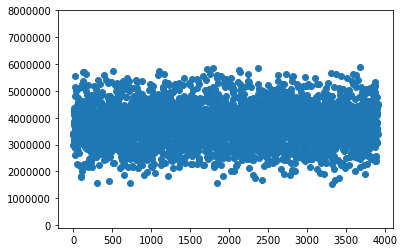

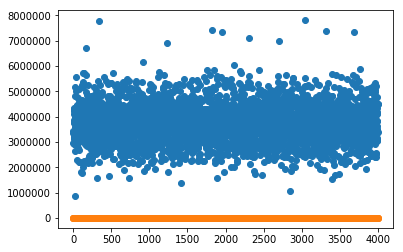

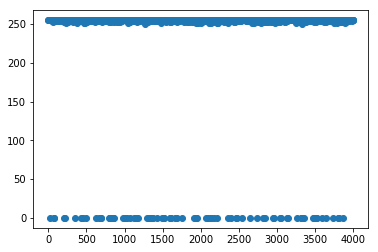

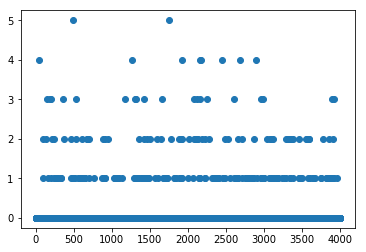

In [33]:
plt.plot(sums[(sums < 6000000) & (sums > 1400000)], 'o'); plt.ylim([-100000,8000000]); plt.show()
plt.plot(sums,'o')
plt.plot(avgs, 'o'); plt.show()
plt.plot(maxs, 'o'); plt.show()
plt.plot(mins, 'o'); plt.show()

In [28]:
sums[(sums < 6000000) & (sums > 1400000)].shape, sums[sums > 1000].shape

((3905,), (3920,))

So this really only eliminates 15 examples. Is this enough to actually help? Does the sum actually account for anything that the model is learning?

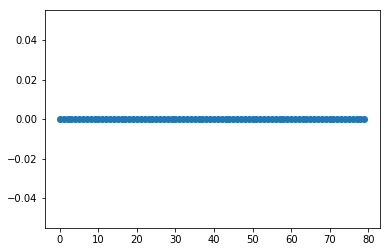

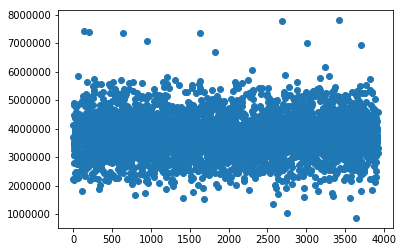

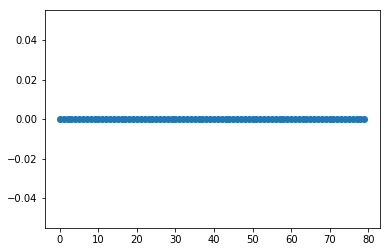

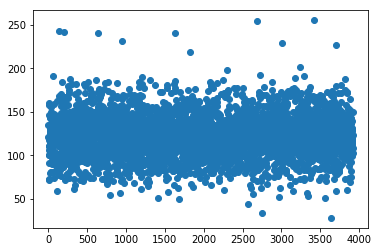

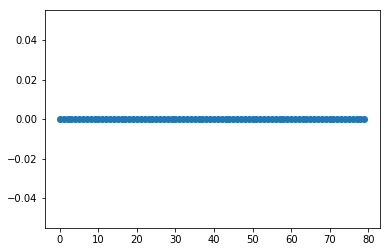

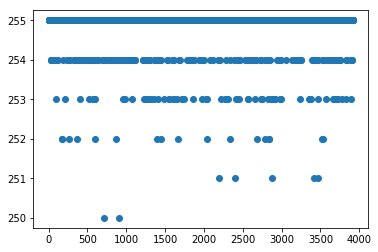

In [36]:
plt.plot(sums[sums < 1000], 'o'); plt.show()
plt.plot(sums[sums >= 1000], 'o'); plt.show()

plt.plot(avgs[avgs < 5], 'o'); plt.show()
plt.plot(avgs[avgs >= 5], 'o'); plt.show()

plt.plot(maxs[maxs < 5], 'o'); plt.show()
plt.plot(maxs[maxs >= 5], 'o'); plt.show()

In [37]:
len(sums[sums < 1000])

80

In [38]:
np.argwhere(sums < 1000).reshape(-1)

array([  90,  127,  186,  197,  217,  263,  336,  379,  380,  408,  437,
        470,  499,  536,  579,  685,  686,  710,  729,  742,  753,  895,
        924,  973, 1032, 1078, 1130, 1158, 1177, 1231, 1320, 1351, 1360,
       1556, 1691, 1727, 1792, 1883, 1951, 2018, 2154, 2197, 2389, 2409,
       2530, 2534, 2560, 2586, 2664, 2690, 2704, 2821, 2873, 2900, 2912,
       2944, 2998, 3032, 3221, 3225, 3252, 3265, 3309, 3410, 3412, 3510,
       3561, 3582, 3615, 3618, 3629, 3656, 3663, 3675, 3679, 3683, 3809,
       3811, 3874, 3936])

So all these arrays are bad. Let's double check that the other attributes overlap (sum, avg, min). Don't do min, there could legitimately be an image where the minimum value is 0.

In [67]:
bad_sum_indx = list(np.argwhere(sums < 1000).reshape(-1))
bad_avg_indx = list(np.argwhere(avgs < 5).reshape(-1))
bad_max_indx = list(np.argwhere(maxs < 5).reshape(-1))

In [72]:
print set(bad_sum_indx) - set(bad_sum_indx).intersection(set(bad_avg_indx))
print set(bad_sum_indx) - set(bad_sum_indx).intersection(set(bad_max_indx))

set([])
set([])


In [78]:
np.unique(images[bad_sum_indx])
np.unique(images[bad_avg_indx])
np.unique(images[bad_max_indx])

array([0], dtype=uint8)

Cool, so nothing cray is going on. That's good to know.

In [73]:
bad_indx = list(np.argwhere(sums < 1000).reshape(-1))

In [76]:
np.unique(masks[bad_indx])

array([0], dtype=uint16)

OK, so these masks are also bad. That's also good to double check. So we are going to have to take these out of our training set, unless we are looking to purposefully mess up our training for absolutely no reason.

Let's check out the depths, see if we can find any correlation. We will still need to include it as a feature I think, because it could still be affecting things we can't see in these simple correlation plots.

In [79]:
depths = pd.read_csv('../depths.csv')

In [80]:
depths.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [87]:
statsdf = pd.DataFrame(map(lambda x: x.split('.')[0],train_image_files), columns=['id'])

In [89]:
statsdf = pd.merge(statsdf, depths, on='id')

In [111]:
statsdf.shape

(4000, 10)

In [94]:
sums_masks = masks.sum(axis=(1,2))
avgs_masks = masks.mean(axis=(1,2))
maxs_masks = masks.max(axis=(1,2))
mins_masks = masks.min(axis=(1,2))

In [95]:
statsdf['sums'] = sums
statsdf['avgs'] = avgs
statsdf['maxs'] = maxs
statsdf['mins'] = mins

statsdf['sums_masks'] = sums_masks
statsdf['avgs_masks'] = avgs_masks
statsdf['maxs_masks'] = maxs_masks
statsdf['mins_masks'] = mins_masks

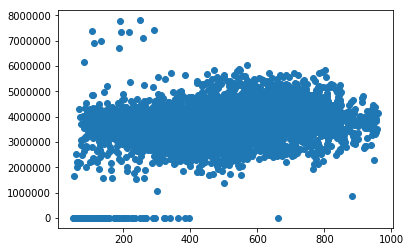

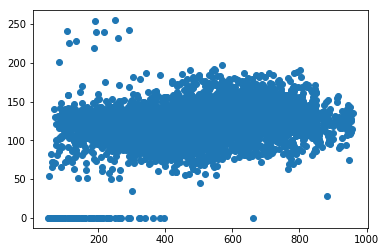

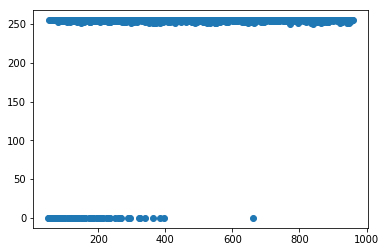

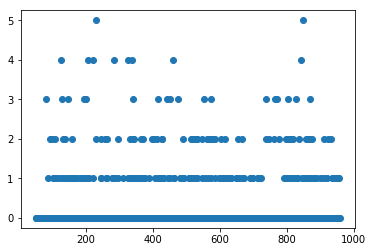

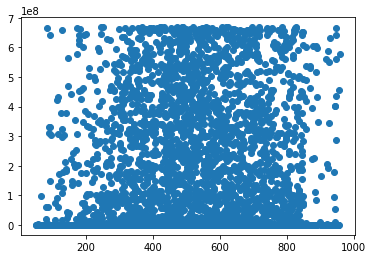

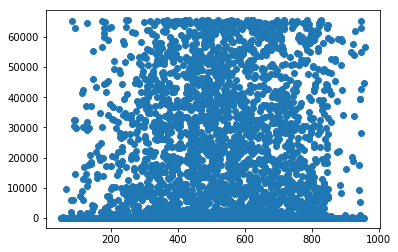

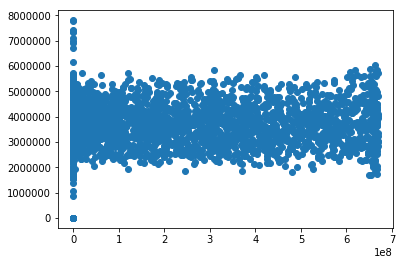

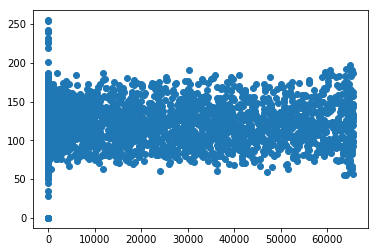

In [99]:
plt.plot(statsdf['z'], statsdf['sums'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['avgs'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['maxs'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['mins'],'o'); plt.show()

plt.plot(statsdf['z'], statsdf['sums_masks'],'o'); plt.show()
plt.plot(statsdf['z'], statsdf['avgs_masks'],'o'); plt.show()
# plt.plot(statsdf['z'], statsdf['maxs_masks'],'o'); plt.show()
# plt.plot(statsdf['z'], statsdf['mins_masks'],'o'); plt.show()

plt.plot(statsdf['sums_masks'], statsdf['sums'],'o'); plt.show()
plt.plot(statsdf['avgs_masks'], statsdf['avgs'],'o'); plt.show()


### Let's take a look at the test data, are we going to run into those weird examples in the test data?

In [103]:
testdir = '../test/'

test_image_files = os.listdir(filter_directory_list(testdir + 'images/'))

In [107]:
test_images = np.array([skimage.io.imread(testdir + 'images/' + x) for x in test_image_files])

In [108]:
test_images.shape

(18000, 101, 101, 3)

In [109]:
test_sums = test_images.sum(axis=(1,2,3))
test_avgs = test_images.mean(axis=(1,2,3))
test_maxs = test_images.max(axis=(1,2,3))
test_mins = test_images.min(axis=(1,2,3))

In [110]:
depths.shape

(22000, 2)

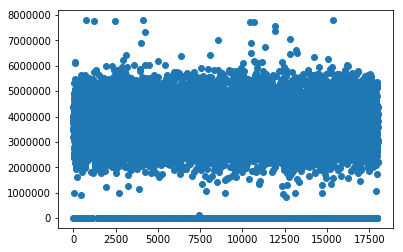

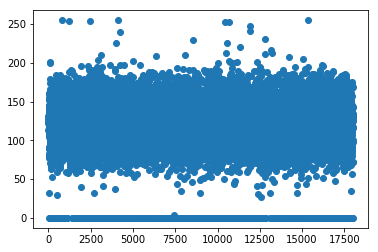

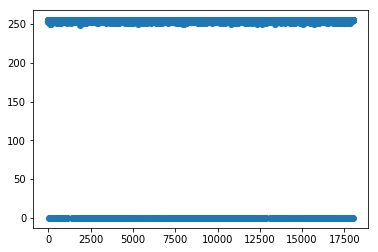

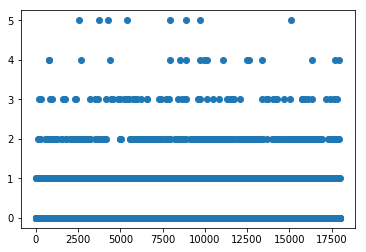

In [112]:
plt.plot(test_sums, 'o'); plt.show()
plt.plot(test_avgs, 'o'); plt.show()
plt.plot(test_maxs, 'o'); plt.show()
plt.plot(test_mins, 'o'); plt.show()

So we are going to have to deal with this as well. In the end, I believe for our training set we will also want to correlate our IOU vs. sum. Obviously we will eliminate any blanks in training. Then we can look at how well we do vs. the sum value, my guess is that those outliers that we see in the training set we will do badly on. It may be that we have to do something clever for them. But I guess let's not solve that problem until we come to it.